## Create colabels

Use:
- This script will create a colabels file from seprate position and label files.

Requirements:
- A folder with position files containing bodyparts and objects.
- One or more folders with labels for those positions.


In [1]:
import pandas as pd
import os

In [ ]:
base = r'c:\Users\dhers\Desktop\create_colabels'

path = os.path.join(base, 'positions')
labelers = ['labels_cande']
targets = ['obj_1', 'obj_2']

In [ ]:
def create_colabels(path, labelers, targets):
    """Creates colabels for a given folder of position files.

    Args:
        path (str): Path to the folder containing position files.
        labelers (list): List of labelers names, each corresponding to a folder.
        targets (list): List of targets.
    """
    # Get list of position files
    position_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
    
    # Initialize list to store concatenated data
    all_data = []
    
    for pos_file in position_files:
        # Load position data
        pos_df = pd.read_csv(pos_file)
        
        # Identify body part columns (excluding object positions)
        bodypart_cols = [col for col in pos_df.columns if not any(col.startswith(f'{obj}') for obj in targets)]
        bodyparts = pos_df[bodypart_cols]
        
        for obj in targets:
            # Extract object position columns
            obj_x = pos_df[f'{obj}_x']
            obj_y = pos_df[f'{obj}_y']
            
            # Load labeler data for this object
            labels = []
            for labeler in labelers:
                label_file = os.path.join(os.path.dirname(path), labeler, os.path.basename(pos_file).replace('_position.csv', '_labels.csv'))
                label_df = pd.read_csv(label_file)
                labels.append(label_df[f'{obj}'])
            
            # Create a DataFrame with object positions, labels, and bodyparts
            obj_data = pd.DataFrame({'obj_x': obj_x, 'obj_y': obj_y})
            for i, label_col in enumerate(labels):
                obj_data[f'{labelers[i]}'] = label_col
            
            # Repeat bodypart positions for each object
            obj_data = pd.concat([bodyparts, obj_data], axis=1)
            
            all_data.append(obj_data)
    
    # Concatenate all targets' data vertically
    colabels_df = pd.concat(all_data, ignore_index=True)
    
    # Save to CSV
    output_file = os.path.join(os.path.dirname(path), 'colabels.csv')
    colabels_df.to_csv(output_file, index=False)
    print(f'Colabels file saved as {output_file}')

In [ ]:
create_colabels(path, labelers, targets)

Colabels file saved as c:\Users\dhers\Desktop\create_colabels\colabels.csv


try out sigmoid transformation

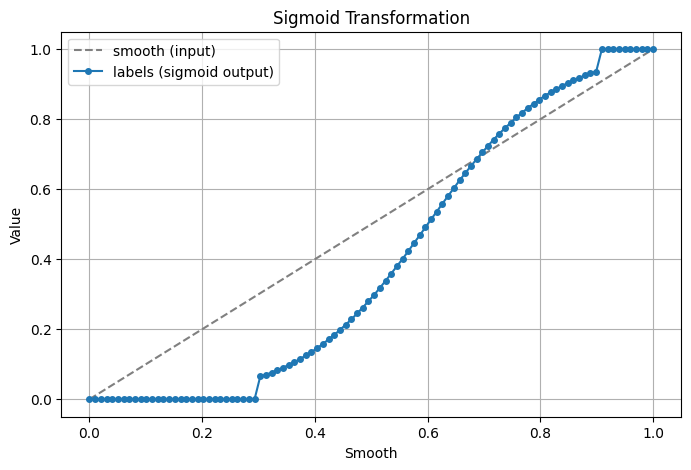

      smooth  sigmoid
0   0.000000      0.0
1   0.010101      0.0
2   0.020202      0.0
3   0.030303      0.0
4   0.040404      0.0
..       ...      ...
95  0.959596      1.0
96  0.969697      1.0
97  0.979798      1.0
98  0.989899      1.0
99  1.000000      1.0

[100 rows x 2 columns]


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def apply_sigmoid_transformation(data):
    """
    Apply a sigmoid function to scale values between 0 and 1.
    Values ≤ 0.3 are set to 0, and values ≥ 0.9 are set to 1.
    """
    sigmoid = 1 / (1 + np.exp(-9 * (data - 0.6)))
    sigmoid = np.round(sigmoid, 3)

    sigmoid[data <= 0.3] = 0  # Set values ≤ 0.3 to 0
    sigmoid[data >= 0.9] = 1  # Set values ≥ 0.9 to 1

    return sigmoid

# Create example sequential data from 0 to 1
example_data = pd.DataFrame({'smooth': np.linspace(0, 1, 100)})

# Apply transformation
example_data['sigmoid'] = apply_sigmoid_transformation(example_data['smooth'])

# Plot both columns
plt.figure(figsize=(8, 5))
plt.plot(example_data['smooth'], example_data['smooth'], label='smooth (input)', linestyle='dashed', color='gray')
plt.plot(example_data['smooth'], example_data['sigmoid'], label='labels (sigmoid output)', marker='o', markersize=4)
plt.xlabel('Smooth')
plt.ylabel('Value')
plt.title('Sigmoid Transformation')
plt.legend()
plt.grid(True)
plt.show()

print(example_data)

Smoothing column: data


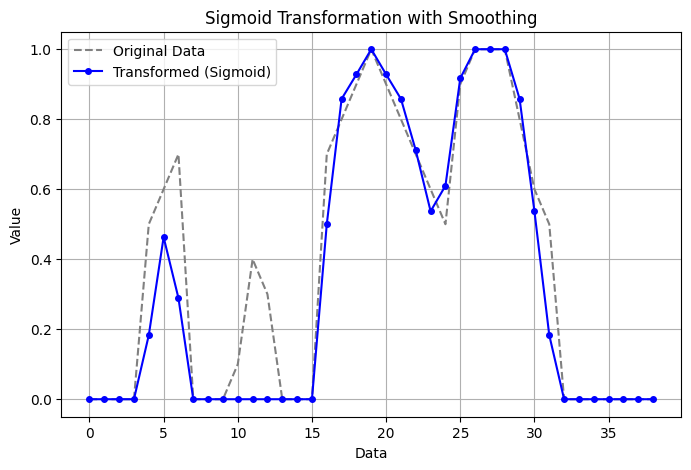

    data
0  0.000
1  0.000
2  0.000
3  0.000
4  0.183


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal

def apply_sigmoid_transformation(data):
    """
    Apply a sigmoid function to scale values between 0 and 1.
    Values ≤ 0.3 are set to 0, and values ≥ 0.9 are set to 1.
    """
    sigmoid = 1 / (1 + np.exp(-9 * (data - 0.6)))
    sigmoid = np.round(sigmoid, 3)

    sigmoid[data <= 0.3] = 0  # Set values ≤ 0.3 to 0
    sigmoid[data >= 0.9] = 1  # Set values ≥ 0.9 to 1

    return sigmoid

def smooth_columns(df: pd.DataFrame, columns: list = [], kernel_size: int = 3, gauss_std: float = 0.6) -> pd.DataFrame:
    """Applies smoothing to a DataFrame column.

    Args:
        df (pd.DataFrame): DataFrame to apply smoothing to.
        columns (list, optional): List of columns to apply smoothing to. Defaults to [].
        kernel_size (int, optional): Size of the smoothing kernel. Defaults to 3.
        gauss_std (float, optional): Standard deviation of the Gaussian kernel. Defaults to 0.6.

    Returns:
        pd.DataFrame: Smoothed & transformed DataFrame.
    """
    
    df = df.copy()  # Avoid modifying the original DataFrame

    if not columns:
        columns = df.columns

    for column in columns:
        print(f'Smoothing column: {column}')

        # Apply median filter
        df['med_filt'] = signal.medfilt(df[column], kernel_size=kernel_size)
        
        # Gaussian kernel
        gauss_kernel = signal.windows.gaussian(kernel_size, gauss_std)
        gauss_kernel /= gauss_kernel.sum()  # Normalize
        
        # Pad to mitigate edge effects
        pad_width = (len(gauss_kernel) - 1) // 2
        padded = np.pad(df['med_filt'], pad_width, mode='edge')
        
        # Apply convolution
        df['smooth'] = signal.convolve(padded, gauss_kernel, mode='valid')[:len(df[column])]
        
        # Apply sigmoid transformation
        df['sigmoid'] = apply_sigmoid_transformation(df['smooth'])

        df[column] = df['sigmoid']

    return df.drop(columns=['med_filt', 'smooth', 'sigmoid'])


# Generate example data (sequential from 0 to 1)
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
y = [0,0,0,0,0.5,0.6,0.7,0,0,0,0.1,0.4,0.3,0,0,0,0.7,0.8,0.9,1,0.9,0.8,0.7,0.6,0.5,0.9,1,1,1,0.8,0.6,0.5,0,0,0,0,0,0,0]

# Create DataFrame
example_data = pd.DataFrame({'data': y})

# Apply transformation
transformed_data = smooth_columns(example_data, ['data'])

# Plot both columns
plt.figure(figsize=(8, 5))
plt.plot(x, example_data['data'], label='Original Data', linestyle='dashed', color='gray')
plt.plot(x, transformed_data['data'], label='Transformed (Sigmoid)', marker='o', markersize=4, color='blue')

# Labels & formatting
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Sigmoid Transformation with Smoothing')
plt.legend()
plt.grid(True)
plt.show()

print(transformed_data.head())  # Display first few rows